# Spark data mining

In [ ]:
# Must be included at the beginning of each new notebook. Remember to change the app name.
import findspark
findspark.init('/home/ubuntu/spark-3.2.1-bin-hadoop2.7')
import warnings
warnings.simplefilter(action='ignore')
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('readin').getOrCreate()

In [ ]:
# Let's read in the data. Note that it's in the csv

#City,Date,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI,AQI_Bucket
#define the schema

# Let's import in the relevant types.
warnings.filterwarnings('ignore')
from pyspark.sql.types import *
Schema=StructType([
  StructField("City",StringType(),nullable=True),
  StructField("Date",StringType(),nullable=True),
  StructField("PM25",FloatType(),nullable=True),
  StructField("PM10",FloatType(),nullable=True),
  StructField("NO",FloatType(),nullable=True),
  StructField("NO2",FloatType(),nullable=True),
  StructField("NOX",FloatType(),nullable=True),
  StructField("NH3",FloatType(),nullable=True),
  StructField("CO",FloatType(),nullable=True),
  StructField("SO2",FloatType(),nullable=True),
  StructField("O3",FloatType(),nullable=True),
  StructField("benzene",FloatType(),nullable=True),
  StructField("toluene",FloatType(),nullable=True),
  StructField("Xylene",FloatType(),nullable=True),
  StructField("AQI",FloatType(),nullable=True),
  StructField("AQIBucket",StringType(),nullable=True)
])
df = spark.read.option("header",True).schema(Schema).csv("Datasets/city_day.csv")

df.show()


## Data Exploration

In [ ]:
# The show method allows you visualise DataFrames. We can see that there are two columns. 
df.show()

# You could also try this. 
df.columns

df.dtypes

df.describe().toPandas()


In [ ]:
# We can use the describe method get some general statistics on our data too. Remember to show the DataFrame!
# But what about data type?
# Then create a variable with the correct structure.
df.describe().show()

In [ ]:
# For type, we can use print schema. 
# But wait! What if you want to change the format of the data? Maybe change age to an integer instead of long?
# And now we can read in the data using that schema. If we print the schema, we can see that age is now an integer.
df.printSchema()

## Data Manipulation

In [ ]:
df.describe().toPandas()

df.groupby('AQIBucket').count().show()


In [ ]:

df.groupby('City').count().show()

In [ ]:
df.count()
# Let's see the data. You'll notice nulls.
df.show()

In [ ]:
# First, we have to register the DataFrame as a SQL temporary view.
df.createOrReplaceTempView('pollution')

# After that, we can use the SQL programming language for queries. 
results = spark.sql("SELECT * FROM pollution")
results.show()

In [ ]:
# After that, we can use the SQL programming language for queries. 
results1 = spark.sql("SELECT city, count(City) FROM pollution where AQI is null group by City")
results1.show()

In [ ]:
# Find count for empty, None, Null, Nan with string literals.
from pyspark.sql.functions import col,isnan,when,count
df2 = df.select([count(when(col(c).contains('None') | \
                            col(c).contains('NULL') | \
                            (col(c) == '' ) | \
                            col(c).isNull() | \
                            isnan(c), c 
                           )).alias(c)
                    for c in df.columns])
df2.show()

In [ ]:
from pyspark.sql.functions import isnan, when, count, col

df.select([count(when(isnan(c), c)).alias(c) for c in df.columns]).show()

# Exploring data with SQL

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore')

fig = plt.figure(figsize=(25,13))
st = fig.suptitle("Distribution of features",fontsize = 50, verticalalignment="center")
for col,num in zip(df.toPandas().describe().columns, range(1,11)):
    ax = fig.add_subplot(3,4, num)
    ax.hist(df.toPandas()[col])
    plt.grid(False)
    plt.xticks(rotation=45, fontsize=20)
    plt.yticks(fontsize=15)
    plt.title(col.upper(), fontsize=20)

plt.tight_layout()
st.set_y(0.95)
fig.subplots_adjust(top=0.85, hspace=0.4)
plt.show()

In [ ]:
#Import all the required functions
from pyspark.sql.functions import year 
df.createOrReplaceTempView('pollution')

results1 = spark.sql("SELECT city, Count(AQIBucket), count(City) FROM pollution where AQIBucket is not null group by City, AQIBucket")
results1.show()


In [ ]:
# Requires a certain amount of non-null values. Row two was dropped, as there's only one non-null value.
df.na.drop(thresh=8).show()

In [ ]:
df.count()

In [ ]:
import sys
###backward fill
from pyspark.sql import Window
from pyspark.sql.functions import first,last

# define the window
window = Window.partitionBy('City')\
               .orderBy('Date')\
               .rowsBetween(0, sys.maxsize)

# define the forward-filled column
filled_column = first(df['PM25'], ignorenulls=True).over(window)

# do the fill
spark_df_filled = df.withColumn('PM25', filled_column)

# show off our glorious achievements
spark_df_filled.orderBy('City', 'Date').show(10) 
spark_df_filled.show()

# define the window
window = Window.partitionBy('City')\
               .orderBy('Date')\
               .rowsBetween(-sys.maxsize,0)

# define the forward-filled column
filled_column = last(spark_df_filled['PM25'], ignorenulls=True).over(window)

# do the fill
spark_df_filled = spark_df_filled.withColumn('PM25', filled_column)
# show off our glorious achievements

spark_df_filled.orderBy('City', 'Date').show(10) 
spark_df_filled.show()


In [ ]:
spark_df_filled.filter(spark_df_filled.PM25.isNull()).show()

In [ ]:
# Find count for empty, None, Null, Nan with string literals.
from pyspark.sql.functions import col,isnan,when,count
df2 = spark_df_filled
df2 = df2.select([count(when(col(c).contains('None') | \
                            col(c).contains('NULL') | \
                            (col(c) == '' ) | \
                            col(c).isNull() | \
                            isnan(c), c 
                           )).alias(c)
                    for c in df2.columns])
df2.show()

In [ ]:
import sys
###backward fill
from pyspark.sql import Window
from pyspark.sql.functions import last, first

# define the window
window = Window.partitionBy('City')\
               .orderBy('Date')\
               .rowsBetween(-sys.maxsize , 0)

# define the forward-filled column
filled_column = last(spark_df_filled['PM10'], ignorenulls=True).over(window)

# do the fill
spark_df_filled = spark_df_filled.withColumn('PM10', filled_column)

# show off our glorious achievements
spark_df_filled.orderBy('City', 'Date').show(10) 
spark_df_filled.show()



# define the window
window = Window.partitionBy('City')\
               .orderBy('Date')\
               .rowsBetween(0, sys.maxsize)

# define the forward-filled column
filled_column= first(spark_df_filled['PM10'], ignorenulls=True).over(window)

# do the fill
spark_df_filled = spark_df_filled.withColumn('PM10', filled_column)

# show off our glorious achievements
spark_df_filled.orderBy('City', 'Date').show(10) 
spark_df_filled.show()

In [ ]:
# First, we have to register the DataFrame as a SQL temporary view.

dff= spark_df_filled
dff.createOrReplaceTempView('pollution')

results = spark.sql("SELECT * FROM pollution where pm10 is null")
results.show()

In [ ]:
dff.filter(dff.PM10.isNull()).show()

In [ ]:
from pyspark.sql.functions import mean
mean_pm10 = dff.select(mean(dff['PM10'])).collect()
mean_pm10[0][0]


In [ ]:


dff1 = dff.na.fill(mean_pm10[0][0], subset=['PM10'])
dff1.filter(dff1.PM10.isNull()).show()

In [ ]:
dff1.show()

In [ ]:

#dff.filter(dff.PM25.isNull()).show()
#from pyspark.sql.functions import isnan, when, count, col

#dff.select([count(when(isNull(c), c)).alias(c) for c in dff.columns]).show()

# Find count for empty, None, Null, Nan with string literals.
from pyspark.sql.functions import col,isnan,when,count

dffs = dff1.select([count(when(col(c).contains('None') | \
                            col(c).contains('NULL') | \
                            (col(c) == '' ) | \
                            col(c).isNull() | \
                            isnan(c), c 
                           )).alias(c)
                    for c in dff.columns])
dffs.show()

In [ ]:
# To Get Year from date or Time column
spark_df_filled = dff1
spark_df_filled1 = spark_df_filled.withColumn("year",year("Date"))


In [ ]:
dff2= spark_df_filled1
dff2.show()



In [ ]:
dff2.createOrReplaceTempView('pollution')

results = spark.sql("SELECT * FROM pollution where PM10 is null")
results.show()

In [ ]:
dff2.count()
dff2.show()

In [ ]:
#df1.show() dff5.show()

In [ ]:
# Let's collect the average. You'll notice that the collection returns the average in an interesting format.
mean_no2 = dff2.select(mean(dff2['NO2'])).collect()
mean_so2 = dff2.select(mean(dff2['SO2'])).collect()
mean_o3 = dff2.select(mean(dff2['O3'])).collect()
#mean_pm10
mean_no2[0][0]
dff3 = dff2.na.fill(mean_no2[0][0], subset=['NO2'])
mean_so2[0][0]
dff4 = dff3.na.fill(mean_so2[0][0], subset=['SO2'])
mean_o3[0][0]
dff5 = dff4.na.fill(mean_o3[0][0], subset=['O3'])



In [ ]:

#df1=df1.drop('date')
from pyspark.sql.functions import col,isnan,when,count

dff6 = dff5.select([count(when(col(c).contains('None') | \
                            col(c).contains('NULL') | \
                            (col(c) == '' ) | \
                            col(c).isNull() | \
                            isnan(c), c 
                           )).alias(c)
                    for c in dff5.columns])
dff6.show()


In [ ]:

dff5.show()

In [ ]:
# Let's collect the average. You'll notice that the collection returns the average in an interesting format.
#mean_pm10 = df.select(mean(df['PM10'])).collect()
#mean_pm10
#mean_pm10[0][0]
#df.filter(df.PM10.isNull()).show()
#df1 = df1.na.fill(mean_pm10[0][0], subset=['PM10'])
#df1.filter(df1.PM10.isNull()).show()

In [ ]:

dftr=dff5.drop('NO')
dftr.show()

In [ ]:


dftr=dftr.drop('NOX')
dftr=dftr.drop('NH3')
dftr=dftr.drop('CO')
dftr=dftr.drop('benzene')
dftr=dftr.drop('toluene')
dftr=dftr.drop('Xylene')

In [ ]:
dftr.show()
#df1=df1.drop('date')
from pyspark.sql.functions import col,isnan,when,count

dftr1 = dftr.select([count(when(col(c).contains('None') | \
                            col(c).contains('NULL') | \
                            (col(c) == '' ) | \
                            col(c).isNull() | \
                            isnan(c), c 
                           )).alias(c)
                    for c in dftr.columns])
dftr1.show()

In [ ]:
#df1 = df1.na.fill(mean_pm10[0][0], subset=['PM10'])
#dftr2.filter(dftr.AQI.isNull()).show()

In [ ]:
#Replace 0 for null on only population column 
#df2 = df2.na.fill(value=0,subset=["AQI"]).show()


In [ ]:
dftr.show()

In [ ]:
import sys
from pyspark.sql.window import Window
import pyspark.sql.functions as func
dftr.withColumn("AQIBucket1", func.last('AQIBucket', True).over(Window.partitionBy('City').orderBy('year').rowsBetween(-sys.maxsize, 0))).show()


In [ ]:

###backward fill
from pyspark.sql import Window
from pyspark.sql.functions import first

# define the window
window = Window.partitionBy('City')\
               .orderBy('Date')\
               .rowsBetween(0, sys.maxsize)

# define the forward-filled column
filled_column = first(dftr['AQIBucket'], ignorenulls=True).over(window)

# do the fill
spark_df_filled = dftr.withColumn('AQIBucket', filled_column)

# show off our glorious achievements
spark_df_filled.orderBy('City', 'Date').show(10) 

In [ ]:
spark_df_filled.show()

In [ ]:
# First, we have to register the DataFrame as a SQL temporary view.
spark_df_filled.createOrReplaceTempView('pollution')

results2 = spark.sql("SELECT * FROM pollution where AQIBucket is null")
results2.show()

In [ ]:
###backward fill
from pyspark.sql import Window
from pyspark.sql.functions import last

# define the window
window = Window.partitionBy('City')\
               .orderBy('Date')\
               .rowsBetween(-sys.maxsize ,0 )

# define the forward-filled column
filled_column = last(spark_df_filled['AQIBucket'], ignorenulls=True).over(window)

# do the fill
spark_df_filled2 = spark_df_filled.withColumn('AQIBucket', filled_column)

# show off our glorious achievements
spark_df_filled2.orderBy('City', 'Date').show(10)

In [ ]:
# First, we have to register the DataFrame as a SQL temporary view.
spark_df_filled2.createOrReplaceTempView('pollution')

results3 = spark.sql("SELECT * FROM pollution where AQIBucket is null")
results3.show()

In [ ]:
# First, we have to register the DataFrame as a SQL temporary view.
spark_df_filled2.createOrReplaceTempView('pollution')

results4 = spark.sql("SELECT AQIBucket, count(AQIBucket),city,year FROM pollution group by AQIbucket,city,year")
results4.show()

In [ ]:
###check the AQI for the rows, and update the nulls

spark_df_filled2.filter(spark_df_filled2.AQI.isNull()).show()

In [ ]:
###backward fill
from pyspark.sql import Window
from pyspark.sql.functions import first

# define the window
window = Window.partitionBy('City')\
               .orderBy('AQIBucket')\
               .rowsBetween(0, sys.maxsize)

# define the forward-filled column
filled_column = first(spark_df_filled2['AQI'], ignorenulls=True).over(window)

# do the fill
spark_df_filled3 = spark_df_filled2.withColumn('AQII', filled_column)

# show off our glorious achievements
spark_df_filled3.orderBy('City', 'AQII').show(10) 

In [ ]:

spark_df_filled3.filter(spark_df_filled3.AQII.isNull()).show()

In [ ]:
# First, we have to register the DataFrame as a SQL temporary view.
spark_df_filled3.createOrReplaceTempView('pollution')

results4 = spark.sql("SELECT count(AQIBucket),AQIBucket,city,year FROM pollution group by AQIbucket,city,year")
results4.show()

In [ ]:
spark_df_filled3.show()

In [ ]:
##transform with String Indexer and OneHotEncoder

from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder


indexer = StringIndexer(inputCol="AQIBucket", outputCol="AQIB_index").fit(spark_df_filled3)
spark_df_ind = indexer.transform(spark_df_filled3)
spark_df_ind.show()


#df3 = encoded


In [ ]:
# First, we have to register the DataFrame as a SQL temporary view.
spark_df_ind.createOrReplaceTempView('pollution')

results4 = spark.sql("SELECT AQIBucket ,AQIB_index, count(AQIB_index), city,year FROM pollution group by AQIBucket, AQIB_index, city,year")
results4.show()
result = spark.sql("Select * from pollution")
result.show()

In [ ]:
###one hot encoder
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder

encoder = OneHotEncoder(inputCol="AQIB_index", outputCol="AQIB_vec")
ohe = encoder.fit(spark_df_ind) # indexer is the existing dataframe, see the question
encoded = ohe.transform(spark_df_ind)
encoded.show()

In [ ]:

spark_df_filled3.dtypes


In [ ]:
catCols = ['AQIBucket']
numCols = ['PM25','PM10','NO2','SO2','O3']
numcolout = ['AQII']

In [ ]:
print(numCols)
print(catCols)
print(numcolout)

In [ ]:
spark_df_filled3.show()

In [ ]:
from pyspark.ml.feature import VectorAssembler, StandardScaler

va = VectorAssembler(inputCols=numCols, outputCol="SS_features")


In [ ]:
temp_train = va.transform(spark_df_filled3)

temp_train.show(2, truncate=False)


In [ ]:
temp_train.select("SS_features").show(5,truncate=False)

In [ ]:
ss=StandardScaler(inputCol="SS_features", outputCol="Scaled")
train1 = ss.fit(temp_train).transform(temp_train)
train1.select("Scaled").show(5,truncate=False)

In [ ]:
train1.show()

In [ ]:
from pyspark.ml.feature import MinMaxScaler
mms = MinMaxScaler(inputCol="SS_features", outputCol="MMScaled")
train = mms.fit(temp_train).transform(temp_train)
train.select("MMScaled").show(5)

In [ ]:
train.show(2, truncate=False)

# linear regression

In [ ]:
from pyspark.ml.feature import VectorAssembler

catCols = ['AQIBucket']
numCols = ['PM25','PM10','NO2','SO2','O3']
numcolout = ['AQII']

# The input columns are the feature column names, and the output column is what you'd like the new column to be named. 
assembler = VectorAssembler(
    inputCols=["PM25","NO2","SO2","O3"],
    outputCol="features")

# Now that we've created the assembler variable, let's actually transform the data.
output = assembler.transform(spark_df_filled3)


# Using print schema, you see that the features output column has been added. 
output.printSchema()

# You can see that the features column is a dense vector that combines the various features as expected.
output.head()

output.select(['features']).toPandas().head()


In [ ]:
# Let's select two columns (the feature and predictor).
# This is now in the appropriate format to be processed by Spark.
final_data = output.select("features",'AQII')
final_data.show()

In [ ]:
# Let's do a randomised 70/30 split. 
# Remember, you can use other splits depending on how easy/difficult it is to train your model.
train_data,test_data = final_data.randomSplit([0.7,0.3])

In [ ]:
# Let's see our training data.
train_data.describe().show()

# And our testing data.
test_data.describe().show()

In [ ]:
#import LinearRegression library
from pyspark.ml.regression import LinearRegression

lr = LinearRegression(labelCol='AQII')
# Fit the model to the data.
lrModel = lr.fit(train_data)

In [ ]:
# Print the coefficients and intercept for linear regression.
print("Coefficients: {} Intercept: {}".format(lrModel.coefficients,lrModel.intercept))

In [ ]:
# Let's evaluate the model against the test data.
test_results = lrModel.evaluate(test_data)

In [ ]:
# Interesting results! This shows the difference between the predicted value and the test data.
test_results.residuals.show()

# Let's get some evaluation metrics (as discussed in the previous linear regression notebook).
print("RSME: {}".format(test_results.rootMeanSquaredError))

In [ ]:
# We can also get the R2 value. 
print("R2: {}".format(test_results.r2))
final_data.describe().show()

In [ ]:
spark_df_filled3.show()

In [ ]:
##transform with String Indexer and OneHotEncoder

from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder


indexer0 = StringIndexer(inputCol="City", outputCol="City_index").fit(spark_df_filled3)
spark_df = indexer0.transform(spark_df_filled3)
spark_df.show()

###one hot encoder

encoder0 = OneHotEncoder(inputCol="City_index", outputCol="City_vec")
ohe = encoder0.fit(spark_df) # indexer is the existing dataframe, see the question
encoded0 = ohe.transform(spark_df)
encoded0.show()





In [ ]:
##transform with String Indexer and OneHotEncoder

indexer1 = StringIndexer(inputCol="AQIBucket", outputCol="AQIB_index").fit(encoded0)
spark_df_ind1 = indexer1.transform(encoded0)
spark_df_ind1.show()



In [ ]:
###one hot encoder

encoder1 = OneHotEncoder(inputCol="AQIB_index", outputCol="AQIB_vec")
ohe1 = encoder1.fit(spark_df_ind1) # indexer is the existing dataframe, see the question
encoded1 = ohe1.transform(spark_df_ind1)
encoded1.show()

In [ ]:
# Now we can assemble all of this as one vector in the features column. 
assembler = VectorAssembler(inputCols=['City_vec','PM25',
 'PM10',
 'NO2',
 'SO2',
 'O3'],outputCol='features')


from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline
# Note that survived is a categorial variable but didn't require any transformation.
# That's because it's already in the format of 1's and 0's. 
log_reg = LogisticRegression(featuresCol='features',labelCol='AQIB_index')


In [ ]:
# Lists everything we want to do. Index data, encode data, assemble data and then pass in the actual model.
pipeline = Pipeline(stages=[indexer0,indexer1,
                           encoder0,encoder1,
                           assembler,log_reg ])
# Train/test split. 
train_data1, test_data1 = spark_df_filled3.randomSplit([0.7,.3])

# Note pipeline. Call it as you would call a machine learning object.
fit_model = pipeline.fit(train_data1)

# Transform test data. 
results = fit_model.transform(test_data1)

# Evaluate the model using the binary classifer.
from pyspark.ml.evaluation import BinaryClassificationEvaluator

my_eval = BinaryClassificationEvaluator(rawPredictionCol='prediction',
                                       labelCol='AQIB_index')

# If we select the actual and predicted results, we can see that some predictions were correct while others were wrong.
results.select('AQIB_index','prediction').show()



In [ ]:
# We can then evaluate using AUC (area under the curve). AUC is linked to ROC.
AUC = my_eval.evaluate(results)

AUC

In [ ]:
train1.show()

In [ ]:
# Import the relevant Python libraries.
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Convert sex to an array using Numpy and plot it using pyplot. 
sexArr = np.array(train1.select('AQIBucket').collect())
plt.hist(sexArr)
plt.show()


In [ ]:
# Not all interpretation has to be visualisations. You can also gain a lot of information with text.
# For example, here we're seeing how much variance our model could account for.
# According to this, the model got 164/209 correct. 
totalResults = results.select('AQIB_index','prediction')


correctResults = totalResults.filter(totalResults['AQIB_INDEX'] == totalResults['prediction'])

countTR = totalResults.count()
print("Correct: " + str(countTR))

countTC = correctResults.count()
print("Total Correct: " + str(countTC)) 

In [ ]:
spark_df_filled3.show()

In [ ]:
# prepare the data
features = ["PM25","PM10","NO2","SO2","O3"]
lr_data = spark_df_filled3.select(col("AQII").alias("label"), *features)
lr_data.printSchema()

# split the dataset into training and test
(training, test) = lr_data.randomSplit([.7, .3], seed = 196)



In [ ]:
# creating the pipeline
vectorAssembler = VectorAssembler(inputCols=features, outputCol="unscaled_features")
standardScaler = StandardScaler(inputCol="unscaled_features", outputCol="features")
lr = LinearRegression(maxIter=10, regParam=.01)

estimators = [vectorAssembler, standardScaler, lr]


# building the model using the pipeline
# https://spark.apache.org/docs/latest/api/python/pyspark.ml.html#pyspark.ml.Pipeline
pipeline = Pipeline(stages=estimators)

model = pipeline.fit(training)


In [ ]:
# prediction
prediction = model.transform(test)

prediction.show()



In [ ]:
# evaluate the model
from pyspark.ml.evaluation import RegressionEvaluator
eval = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")

# Root Mean Square Error

rmse = eval.evaluate(prediction)
print("RMSE: %.3f" % rmse)

# Mean Square Error

mse = eval.evaluate(prediction, {eval.metricName: "mse"})
print("MSE: %.3f" % mse)

# Mean Absolute Error

mae = eval.evaluate(prediction, {eval.metricName: "mae"})
print("MAE: %.3f" % mae)

# r2 - coefficient of determination

r2 = eval.evaluate(prediction, {eval.metricName: "r2"})
print("r2: %.3f" %r2)

In [ ]:
spark_df_filled3.show()

In [ ]:
assembler = VectorAssembler(inputCols=['PM25',
 'PM10',
 'NO2',
 'SO2',
 'O3','AQII'],outputCol="features")

# Let's transform the data. 
output = assembler.transform(spark_df_filled3)

# Let's select the two columns we want. Features (which contains vectors), and the predictor.
indexer = StringIndexer(inputCol="AQIBucket", outputCol="AQIB_index")
output_fixed = indexer.fit(output).transform(output)

In [114]:
#output.show()
spark_df_ind.show()

+---------+----------+------+------+--------+---------+---------+-----+---------+----+-----+----------+
|     City|      Date|  PM25|  PM10|     NO2|      SO2|       O3|  AQI|AQIBucket|year| AQII|AQIB_index|
+---------+----------+------+------+--------+---------+---------+-----+---------+----+-----+----------+
|Ahmedabad|2015-07-24| 29.22|141.54|    9.57|    13.58|     5.08| 48.0|     Good|2015| 48.0|       4.0|
|Ahmedabad|2015-02-05| 58.36|141.54|   21.39|    32.66|    53.54|149.0| Moderate|2015|149.0|       0.0|
|Ahmedabad|2015-02-06| 79.29|141.54|   26.94|    67.41|     59.3|190.0| Moderate|2015|190.0|       0.0|
|Ahmedabad|2015-02-26| 61.12|141.54|28.56066|14.531978|34.491432| null| Moderate|2015|189.0|       0.0|
|Ahmedabad|2015-02-27| 61.12|141.54|28.56066|14.531978|34.491432| null| Moderate|2015|189.0|       0.0|
|Ahmedabad|2015-02-28| 61.12|141.54|28.56066|14.531978|34.491432| null| Moderate|2015|189.0|       0.0|
|Ahmedabad|2015-03-01| 61.12|141.54|   16.81|    28.44|    30.48

In [ ]:
###AQIB_index

# Now we can assemble all of this as one vector in the features column. 


# Let's select the two columns we want. Features (which contains vectors), and the predictor.

final_data = output_fixed.select('features','AQIB_index')

# Split the training and testing set.
train_data,test_data = final_data.randomSplit([0.7,0.3])

# Let's import the relevant classifiers. 
from pyspark.ml.classification import DecisionTreeClassifier,GBTClassifier,RandomForestClassifier
from pyspark.ml import Pipeline

# Use defaults to make the comparison "fair". This simplifies the comparison process.

dtc = DecisionTreeClassifier(labelCol='AQIB_index',featuresCol='features')
rfc = RandomForestClassifier(labelCol='AQIB_index',featuresCol='features')
gbt = GBTClassifier(labelCol='AQIB_index',featuresCol='features')

# Train the models (it's three models, so it might take some time).
dtc_model = dtc.fit(train_data)
rfc_model = rfc.fit(train_data)
#gbt_model = gbt.fit(train_data)

dtc_predictions = dtc_model.transform(test_data)
rfc_predictions = rfc_model.transform(test_data)
#gbt_predictions = gbt_model.transform(test_data)

In [ ]:
# Let's start off with binary classification.
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Note that the label column isn't named label, it's named PrivateIndex in this case.
my_binary_eval = BinaryClassificationEvaluator(rawPredictionCol='prediction',
                                       labelCol='AQIB_index')

# This is the area under the curve. This indicates that the data is highly seperable.
print("DTC")
print(my_binary_eval.evaluate(dtc_predictions))

# RFC improves accuracy but also model complexity. RFC outperforms DTC in nearly every situation.
print("RFC")
print(my_binary_eval.evaluate(rfc_predictions))


# kmeans unsupervised learning

In [120]:
import pandas as pd

from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import KMeans
from pyspark.ml import Pipeline

assembler = VectorAssembler(inputCols=['PM25',
 'PM10',
 'NO2',
 'SO2',
 'O3','AQII'],outputCol="features")

spark_df_indk=spark_df_ind
spark_df_indk=spark_df_indk.drop("AQIB_index")

assembled_data=assembler.transform(spark_df_indk)
assembled_data.show(2)


+---------+----------+-----+------+-----+-----+-----+-----+---------+----+-----+--------------------+
|     City|      Date| PM25|  PM10|  NO2|  SO2|   O3|  AQI|AQIBucket|year| AQII|            features|
+---------+----------+-----+------+-----+-----+-----+-----+---------+----+-----+--------------------+
|Ahmedabad|2015-07-24|29.22|141.54| 9.57|13.58| 5.08| 48.0|     Good|2015| 48.0|[29.2199993133544...|
|Ahmedabad|2015-02-05|58.36|141.54|21.39|32.66|53.54|149.0| Moderate|2015|149.0|[58.3600006103515...|
+---------+----------+-----+------+-----+-----+-----+-----+---------+----+-----+--------------------+
only showing top 2 rows



In [ ]:

#from pyspark.ml.feature import StandardScaler
#scale=StandardScaler(inputCol='features',outputCol='standardized')
#data_scale=scale.fit(assembled_data)
#data_scale_output=data_scale.transform(assembled_data)
#data_scale_output.show(2)

Silhouette Score: 0.7417176461544878


Silhouette Score: 0.7353202300231542


Silhouette Score: 0.702905586996038


Silhouette Score: 0.5473996797430872


Silhouette Score: 0.5308338119724978


Silhouette Score: 0.48264658535544414


Silhouette Score: 0.49968081941339176


Silhouette Score: 0.519801966842245


Text(0, 0.5, 'cost')

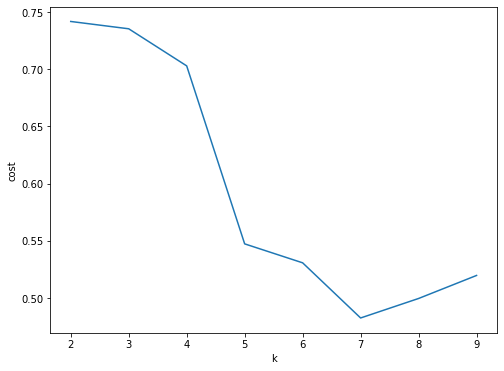

In [121]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
silhouette_score=[]

evaluator = ClusteringEvaluator(featuresCol='features', \
metricName='silhouette', distanceMeasure='squaredEuclidean')

#evaluator = ClusteringEvaluator( featuresCol='standardized', \
#                                metricName='silhouette', distanceMeasure='squaredEuclidean')
for i in range(2,10):
    
    KMeans_algo=KMeans(featuresCol='features', k=i)
    
    KMeans_fit=KMeans_algo.fit(data_scale_output)
    
    output=KMeans_fit.transform(data_scale_output)
    
    
    
    score=evaluator.evaluate(output)
    
    silhouette_score.append(score)
    
    print("Silhouette Score:",score)
    
    
#Visualizing the silhouette scores in a plot
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,10),silhouette_score)
ax.set_xlabel('k')
ax.set_ylabel('cost')

In [135]:
KMeans_=KMeans(featuresCol='features', k=2) 
KMeans_Model=KMeans_.fit(assembled_data)
KMeans_Assignments=KMeans_Model.transform(assembled_data)

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

from pyspark.ml.feature import PCA as PCAml
pca = PCAml(k=2, inputCol="features", outputCol="pca")
pca_model = pca.fit(assembled_data)
pca_transformed = pca_model.transform(assembled_data)







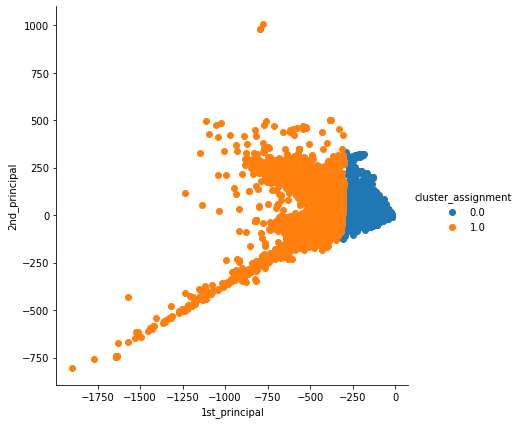

In [136]:
import numpy as np
x_pca = np.array(pca_transformed.rdd.map(lambda row: row.pca).collect())

cluster_assignment = np.array(KMeans_Assignments.rdd.map(lambda row: row.prediction).collect()).reshape(-1,1)



import seaborn as sns
import matplotlib.pyplot as plt

pca_data = np.hstack((x_pca,cluster_assignment))

pca_df = pd.DataFrame(data=pca_data, columns=("1st_principal", "2nd_principal","cluster_assignment"))
sns.FacetGrid(pca_df,hue="cluster_assignment", height=6).map(plt.scatter, '1st_principal', '2nd_principal' ).add_legend()

plt.show()






In [127]:
spark_df_indk.printSchema()
spark_df_indk.show(truncate=False)

results = pd.DataFrame(pca_transformed,columns=['pca1','pca2'])
sns.scatterplot(x="pca1", y="pca2", hue=kmeans['clusters'], data=results)
plt.title('K-means Clustering with 2 dimensions')
plt.show()


root
 |-- City: string (nullable = true)
 |-- Date: string (nullable = true)
 |-- PM25: float (nullable = true)
 |-- PM10: float (nullable = false)
 |-- NO2: float (nullable = false)
 |-- SO2: float (nullable = false)
 |-- O3: float (nullable = false)
 |-- AQI: float (nullable = true)
 |-- AQIBucket: string (nullable = true)
 |-- year: integer (nullable = true)
 |-- AQII: float (nullable = true)



+---------+----------+------+------+--------+---------+---------+-----+---------+----+-----+
|City     |Date      |PM25  |PM10  |NO2     |SO2      |O3       |AQI  |AQIBucket|year|AQII |
+---------+----------+------+------+--------+---------+---------+-----+---------+----+-----+
|Ahmedabad|2015-07-24|29.22 |141.54|9.57    |13.58    |5.08     |48.0 |Good     |2015|48.0 |
|Ahmedabad|2015-02-05|58.36 |141.54|21.39   |32.66    |53.54    |149.0|Moderate |2015|149.0|
|Ahmedabad|2015-02-06|79.29 |141.54|26.94   |67.41    |59.3     |190.0|Moderate |2015|190.0|
|Ahmedabad|2015-02-26|61.12 |141.54|28.56066|14.531978|34.491432|null |Moderate |2015|189.0|
|Ahmedabad|2015-02-27|61.12 |141.54|28.56066|14.531978|34.491432|null |Moderate |2015|189.0|
|Ahmedabad|2015-02-28|61.12 |141.54|28.56066|14.531978|34.491432|null |Moderate |2015|189.0|
|Ahmedabad|2015-03-01|61.12 |141.54|16.81   |28.44    |30.48    |null |Moderate |2015|189.0|
|Ahmedabad|2015-03-02|60.78 |141.54|18.21   |29.48    |34.75    |189.0

In [128]:
pca_data

array([[-107.63887621,  103.40503395,    1.        ],
       [-206.30646546,   61.04307343,    4.        ],
       [-250.34367011,   44.45052225,    4.        ],
       ...,
       [-358.0330861 ,   -2.81806213,    2.        ],
       [-380.86561543,   42.14086501,    2.        ],
       [-472.75461535,  159.45115553,    0.        ]])

In [129]:
pca_df = pandasDF(data=pca_data, columns=("1st_principal", "2nd_principal","cluster_assignment"))
sns.FacetGrid(pca_df,hue="cluster_assignment", height=6).map(plt.scatter, '1st_principal', '2nd_principal' ).add_legend()

plt.show()




reduced_data = PCA(n_components=2).fit_transform(data)
results = pd.DataFrame(reduced_data,columns=['pca1','pca2'])
sns.scatterplot(x="pca1", y="pca2", hue=kmeans['clusters'], data=results)
plt.title('K-means Clustering with 2 dimensions')
plt.show()




TypeError: 'DataFrame' object is not callable